### Predict future loan demand or interest rates using time series analysis.

In [17]:
# Import necessary libraries
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

# Initialize Fred API with your API key
fred = Fred(api_key='dc7c3ec781759add86587b96ae2c8b0a')

# Fetch U.S. 10-Year Treasury Constant Maturity Rate (DGS10)
data = fred.get_series('DGS10')
#data = fred.get_series_vintage_dates('DGS10')

# Convert to a pandas DataFrame
data = pd.DataFrame(data, columns=['Interest Rate'])
data.index.name = 'Date'
data.reset_index(inplace=True)

# Display first few rows of the data
print(data.head())


        Date  Interest Rate
0 1962-01-02           4.06
1 1962-01-03           4.03
2 1962-01-04           3.99
3 1962-01-05           4.02
4 1962-01-08           4.03


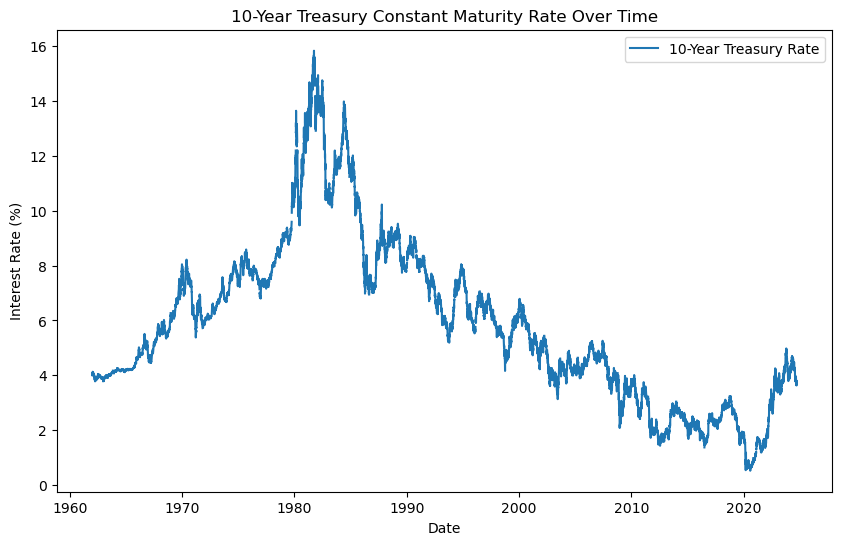

In [18]:
# Plot the interest rates over time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='10-Year Treasury Rate')
plt.title('10-Year Treasury Constant Maturity Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

In [19]:
#Check for stationarity with ADF Test
adf_result = adfuller(data['Interest Rate'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.683651597947681
p-value: 0.4395547377651342


Training data shape: (15239, 1)
Testing data shape: (1129, 1)


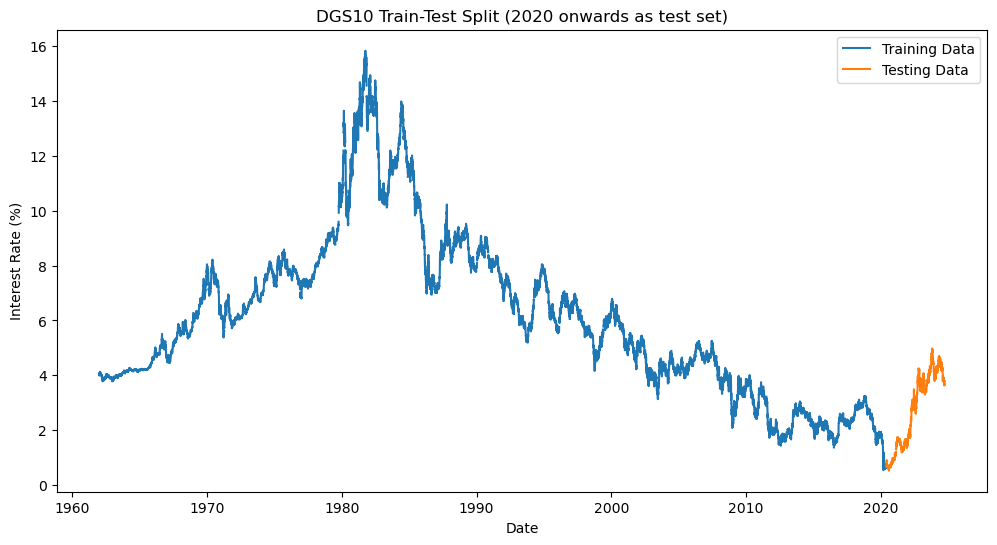

In [20]:
# Convert 'Date' to datetime if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date to ensure chronological order
data = data.sort_values('Date')

# Split the data
train_data = data[data['Date'] < '2020-06-01']
test_data = data[data['Date'] >= '2020-06-01']

# Set the date as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Testing Data')
plt.title('DGS10 Train-Test Split (2020 onwards as test set)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

In [21]:
# Remove NaN values
mask = ~(aligned_forecast.isna() | aligned_test.isna())
aligned_forecast = aligned_forecast[mask]
aligned_test = aligned_test[mask]

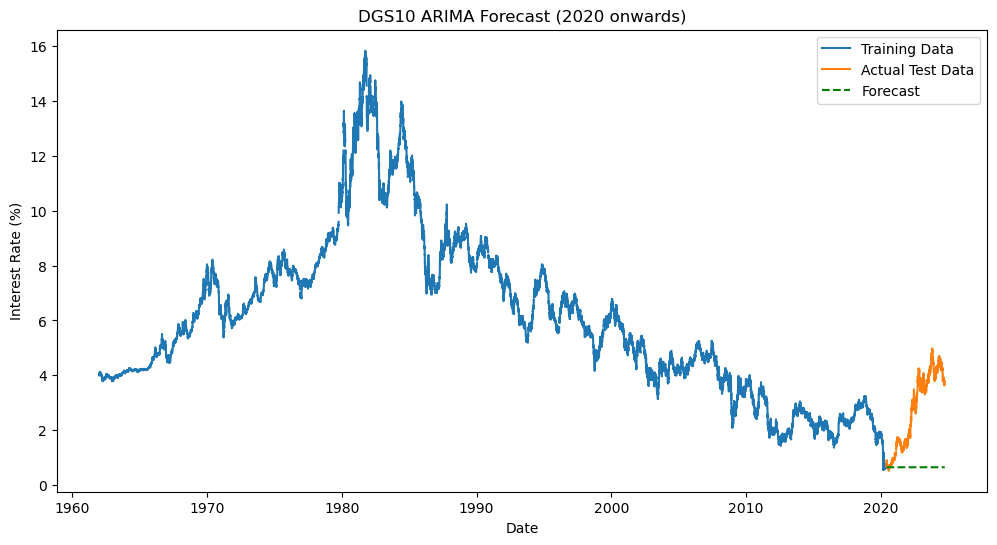

In [24]:

# Fit ARIMA model
model = ARIMA(train_data['Interest Rate'], order=(2,1,2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
#rmse = np.sqrt(mean_squared_error(test_data['Interest Rate'], forecast))
#print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Actual Test Data')
plt.plot(test_data.index, forecast, label='Forecast', color='green', linestyle='--')
plt.title('DGS10 ARIMA Forecast (2020 onwards)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:          Interest Rate   No. Observations:                16368
Model:                 ARIMA(1, 1, 1)   Log Likelihood               20638.966
Date:                Mon, 30 Sep 2024   AIC                         -41271.933
Time:                        22:19:09   BIC                         -41248.824
Sample:                             0   HQIC                        -41264.298
                              - 16368                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0702      0.074      0.943      0.346      -0.076       0.216
ma.L1         -0.0090      0.075     -0.119      0.905      -0.156       0.138
sigma2         0.0041   1.99e-05    203.804      0.0

ValueError: x and y must have same first dimension, but have shapes (16367,) and (16368,)

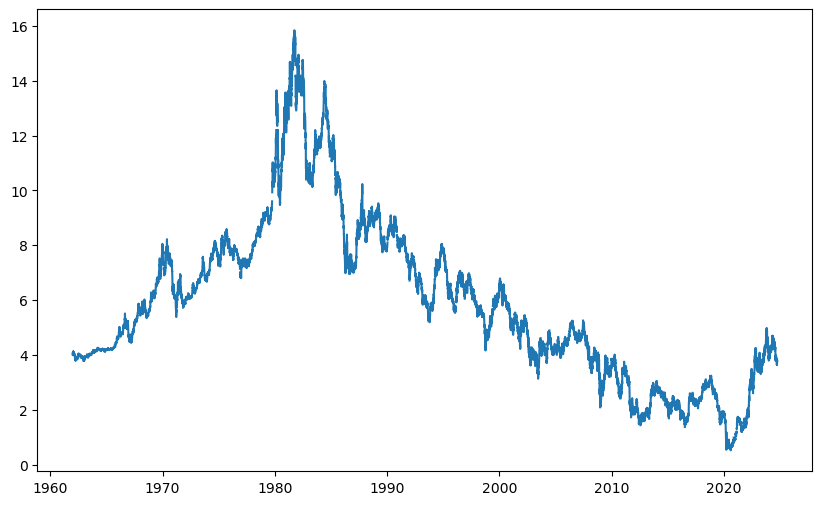

In [23]:

# Step 3: Fit ARIMA model (Assuming p, d, q = 1, 1, 1 for simplicity)
model = ARIMA(data['Interest Rate'], order=(1, 1, 1))
arima_result = model.fit()

# Display ARIMA model summary
print(arima_result.summary())

# Step 4: Plot the fitted values vs actual interest rate data
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='Actual Data')
plt.plot(data['Date'][1:], arima_result.fittedvalues, color='red', label='Fitted ARIMA Model')
plt.title('ARIMA Model Fitted vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Step 5: Forecast next 12 months using the ARIMA model
forecast = arima_result.forecast(steps=12)

# Create a new date index for the forecasted values
forecast_dates = pd.date_range(start=data['Date'].iloc[-1], periods=12, freq='M')

# Plot the actual data along with the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='Historical Data')
plt.plot(forecast_dates, forecast, label='Forecasted Data', color='red')
plt.title('Forecast for U.S. 10-Year Treasury Rate')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

# Step 6: Calculate evaluation metrics (MAE, RMSE)
y_true = data['Interest Rate'].dropna()
y_pred = arima_result.fittedvalues

mae = mean_absolute_error(y_true[1:], y_pred)
rmse = np.sqrt(mean_squared_error(y_true[1:], y_pred))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
